##### Import

In [ ]:
import warnings
import papermill as pm
import scrapbook as sb
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm
import shap
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.pipeline import Pipeline
import os
import gc
import sys

# Filter out warning messages
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)

# Set seaborn style
sns.set_style('whitegrid')

# Add the parent directory to sys.path
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Index and deciles for data slicing
idx = pd.IndexSlice

In [ ]:
# from pathlib import Path
# import pandas as pd
# from utils import rank_stocks_and_quantile
# # UNSEEN_KEY = '/data/YEAR_20220803_20230803'
# top = 250  # parameters -> papermill
# DATA_STORE = Path(f'data/{top}_dataset.h5')
# with pd.HDFStore(DATA_STORE) as store:
#     # unseen = store[UNSEEN_KEY]
#     print(store.keys())

In [ ]:
import gc
import pandas as pd
from utils import rank_stocks_and_quantile

top = 250  # parameters -> papermill

DATA_STORE = Path(f'data/{top}_dataset.h5')
dataset_keys = [
    '/data/YEAR_20200930_20220802',
    # '/data/YEAR_20181024_20200929',
    # '/data/YEAR_20161116_20181023',
    # '/data/YEAR_20141210_20161115'
]
target_string = 'TARGET_ret_fwd'  # no longer a parameter

# Initialize empty dataset
dataset = pd.DataFrame()

with pd.HDFStore(DATA_STORE) as store:
    for key in dataset_keys:
        df = store[key]
        dataset = pd.concat([dataset, df], ignore_index=False)
        del df
        gc.collect()  # Explicitly call garbage collector

# Rank stocks and quantile
dataset = rank_stocks_and_quantile(dataset, target_substring=target_string)

# Adjust timezone
dataset.index.set_levels(dataset.index.levels[0].tz_localize(None), level=0, inplace=True)
dataset.info()

In [ ]:
# dataset = dataset.head(10**4)

In [ ]:
import pandas as pd

# Extract the first and last dates from the MultiIndex
start_date = dataset.index.get_level_values(0).min()
end_date = dataset.index.get_level_values(0).max()

# Generate business dates between the start and end date
business_dates = pd.bdate_range(start_date, end_date)

# Count the number of business days
num_business_days = len(business_dates)

print(f"Number of business days between {start_date} and {end_date}: {num_business_days}")

In [ ]:
def sharpe_ratio_lgbm(preds, train_data):
    """Custom Sharpe ratio eval metric for lightgbm."""
    labels = train_data.get_label()
    if not isinstance(train_data.data.index, pd.MultiIndex):
        raise ValueError("Expecting a MultiIndex with date as the first level")

    grouped_labels = pd.Series(labels, index=train_data.data.index).groupby(level=0)
    grouped_preds = pd.Series(preds, index=train_data.data.index).groupby(level=0)

    daily_scores = []
    for (_, actuals_for_day), (_, preds_for_day) in zip(grouped_labels, grouped_preds):
        score_for_day = spearmanr(actuals_for_day, preds_for_day)[0]
        daily_scores.append(score_for_day if not np.isnan(score_for_day) else 0)

    sharpe_ratio = np.mean(daily_scores) / (np.std(daily_scores) + 1e-9)
    return 'sharpe_ratio', sharpe_ratio, True


def mean_ic_for_fold(preds, train_data):
    """Compute average IC for the entire fold."""
    labels = train_data.get_label()
    if not isinstance(train_data.data.index, pd.MultiIndex):
        raise ValueError("Expecting a MultiIndex with date as the first level")

    grouped_labels = pd.Series(labels, index=train_data.data.index).groupby(level=0)
    grouped_preds = pd.Series(preds, index=train_data.data.index).groupby(level=0)

    daily_ic_scores = []
    for (_, actuals_for_day), (_, preds_for_day) in zip(grouped_labels, grouped_preds):
        ic_score_for_day = spearmanr(actuals_for_day, preds_for_day)[0]
        daily_ic_scores.append(ic_score_for_day if not np.isnan(ic_score_for_day) else 0)

    return 'IC', np.mean(daily_ic_scores), True

def mean_custom_metrics_for_fold(preds, train_data):
    """Compute average MAE, MSE, RMSE, and R^2 for the entire fold."""
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    labels = train_data.get_label()
    if not isinstance(train_data.data.index, pd.MultiIndex):
        raise ValueError("Expecting a MultiIndex with date as the first level")

    grouped_labels = pd.Series(labels, index=train_data.data.index).groupby(level=0)
    grouped_preds = pd.Series(preds, index=train_data.data.index).groupby(level=0)

    mae_scores, mse_scores, rmse_scores, r2_scores = [], [], [], []
    for (_, actuals_for_day), (_, preds_for_day) in zip(grouped_labels, grouped_preds):
        mae_scores.append(mean_absolute_error(actuals_for_day, preds_for_day))
        mse_scores.append(mean_squared_error(actuals_for_day, preds_for_day))
        rmse_scores.append(np.sqrt(mse_scores[-1]))
        r2_scores.append(r2_score(actuals_for_day, preds_for_day))

    return [('MAE', np.mean(mae_scores), False),
            ('MSE', np.mean(mse_scores), False),
            ('RMSE', np.mean(rmse_scores), False),
            ('R2', np.mean(r2_scores), True)]

def combined_fold_metrics(preds, train_data):
    ic_result = mean_ic_for_fold(preds, train_data)
    sharpe_ratio_result = sharpe_ratio_lgbm(preds, train_data)
    custom_metrics_results = mean_custom_metrics_for_fold(preds, train_data)
    
    return [ic_result, sharpe_ratio_result] + custom_metrics_results

In [ ]:
def compute_fold_metrics(era_scores, weights=None):
    era_scores = pd.Series(era_scores)
    
    # Calculate metrics
    mean_correlation = np.mean(era_scores)
    std_deviation = np.std(era_scores)
    sharpe_ratio = mean_correlation / std_deviation
    max_dd = (era_scores.cummax() - era_scores).max()

    # Smart Sharpe
    smart_sharpe = mean_correlation \
        / (std_deviation + np.std(era_scores.diff()))
    
    # Autocorrelation
    autocorrelation = era_scores.autocorr()

    metrics = pd.Series({
        'mean_correlation': mean_correlation,
        'std_deviation': std_deviation,
        'sharpe_ratio': sharpe_ratio,
        'smart_sharpe': smart_sharpe,
        'autocorrelation': autocorrelation,
        'max_dd': max_dd,
        'min_correlation': era_scores.min(),
        'max_correlation': era_scores.max(),
    })

    if weights:
        normalized_metrics = (metrics - metrics.min()) / (metrics.max() - metrics.min())
        weighted_values = normalized_metrics.multiply(pd.Series(weights))
        metrics["weighted_score"] = weighted_values.sum()

    _ = gc.collect()

    return metrics

In [ ]:
import numpy as np
from scipy.stats import rankdata

def pairwise_ranking_objective(y_pred, dataset):
    y_true = dataset.get_label()

    # Sort y_pred based on y_true values
    sorted_pred = y_pred[np.argsort(y_true)]

    # Compute the pairwise differences for sorted_pred
    diff_vector = np.diff(sorted_pred)

    # Convert differences to gradients using the sigmoid function
    sigmoid_diff = 1.0 / (1.0 + np.exp(-diff_vector))
    grad = -1.0 + 2.0 * sigmoid_diff
    
    # Compute hessian
    hess = sigmoid_diff * (1.0 - sigmoid_diff)

    # Append zero at the end of grad and hess to match the length
    grad = np.append(grad, 0)
    hess = np.append(hess, 0)

    return grad, hess

def mse_objective(y_pred, dataset):
    y_true = dataset.get_label()
    residual = (y_pred - y_true).astype("float")
    grad = residual
    hess = np.ones_like(residual)
    return grad, hess

def spearman_corr_objective(y_pred, dataset):
    y_true = dataset.get_label()

    # Calculating the ranked values of y_true and y_pred using rankdata
    rank_pred = rankdata(y_pred)
    rank_true = rankdata(y_true)

    # Calculating Spearman correlation
    n = len(y_pred)
    diff = rank_pred - rank_true
    rho = 1 - (6 * np.sum(diff**2) / (n * (n**2 - 1)))

    # Gradient and Hessian are approximated as Spearman's correlation is non-differentiable
    grad = -rho * np.ones_like(y_pred)
    hess = np.ones_like(y_pred)
    
    return grad, hess

def combined_objective(y_pred, dataset, alpha=0.5, beta=0.25):
    grad_rank, hess_rank = pairwise_ranking_objective(y_pred, dataset)
    grad_mse, hess_mse = mse_objective(y_pred, dataset)
    grad_spearman, hess_spearman = spearman_corr_objective(y_pred, dataset)

    grad = alpha * grad_rank + beta * grad_spearman + (1 - alpha - beta) * grad_mse
    hess = alpha * hess_rank + beta * hess_spearman + (1 - alpha - beta) * hess_mse

    return grad, hess

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
import mlflow
import mlflow.lightgbm
from optuna.integration import LightGBMPruningCallback
from scipy.stats import spearmanr
import warnings

warnings.filterwarnings('ignore')

evals_result = {}

def get_categoricals(dataset, threshold):
    return [col for col in dataset.columns if \
            dataset[col].nunique() < threshold and \
            dataset[col].ge(0).all() and col.startswith("FEATURE_")]

def objective(trial, data, features):
    # Dynamic categoricals based on the trial's suggested threshold
    cat_threshold = trial.suggest_int('cat_threshold', 5, 50)
    categoricals = get_categoricals(data, cat_threshold)
    # Define the features and label columns
    # features = [col for col in dataset.columns if col.startswith('FEATURE_')]
    params = {
        'boosting': 'gbdt',
        'objective': combined_objective, #'regression', # custom_loss,
        'verbose': -1,
        'metric': 'None',
        'device': 'gpu',
        'num_leaves': trial.suggest_int('num_leaves', 30, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        # 'lookahead': trial.suggest_int('lookahead', [1, 5, 21])  # Suggest lookahead as a parameter
        'lookahead': trial.suggest_categorical('lookahead', [1, 5, 21]),
        'x': trial.suggest_int('x', 8, 12),
        'val_period_length': trial.suggest_categorical('val_period_length', [5, 10, 21])
        # 'train_period_length': trial.suggest_categorical('train_period_length', [5, 10, 21])

    }

    early_stopping = lgb.early_stopping(stopping_rounds=500, verbose=True, first_metric_only=True)
    # daily_scores_in_fold = []
    daily_sharpe_in_fold = []

    # Instantiate the CV object
    cv = CustomBackwardMultipleTimeSeriesCV(dataset, train_period_length= int(21 * params['x']), 
                                        test_period_length=params['val_period_length'], 
                                        lookahead=1,  # Starting value; we'll adjust it next.
                                        date_idx='date')

    # Update the CV's lookahead based on the trial's suggestion
    cv.update_lookahead(params["lookahead"])

    for train_idx, val_idx in cv:
        # Dynamic target based on the suggested lookahead
        label = f'TARGET_ret_fwd_{params["lookahead"]:02d}d_rank_quantiled'

        train_features = data.loc[train_idx, features]
        train_labels = data.loc[train_idx, label]
        lgb_train = lgb.Dataset(data=train_features, label=train_labels, 
                        categorical_feature=categoricals, free_raw_data=False)

        val_features = data.loc[val_idx, features]
        val_labels = data.loc[val_idx, label]
        lgb_val = lgb.Dataset(data=val_features, label=val_labels, 
                categorical_feature=categoricals, free_raw_data=False)

        model = lgb.train(params=params,
                          train_set=lgb_train,
                          num_boost_round=5000,
                          valid_sets=[lgb_train, lgb_val],
                          valid_names=['train', 'valid_0'],
                          feval=combined_fold_metrics, 
                          callbacks=[lgb.record_evaluation(evals_result),
                                     early_stopping,
                                     LightGBMPruningCallback(trial, 'sharpe_ratio')])

        # daily_scores_in_fold.extend(evals_result['valid_0']['sharpe_ratio'])
        daily_sharpe_in_fold.extend(evals_result['valid_0']['sharpe_ratio'])

    weights = {
        'mean_correlation': 0.0,
        'std_deviation': -0.025, # Mild penalty for higher volatility
        'sharpe_ratio': 0.95,    # Primary objective, so highest weight
        'smart_sharpe': 0.075,   # Supplementary to Sharpe Ratio but considering autocorrelation
        'autocorrelation': -0.1, # Penalize strategies showing signs of overfitting
        'max_dd': -0.1,          # Major risk metric, negative to penalize higher drawdowns
        'min_correlation': 0.0,
        'max_correlation': 0.0,
    }

    # metrics = metrics_on_fold(daily_scores_in_fold, weights=weights)
    metrics = compute_fold_metrics(daily_sharpe_in_fold, weights=weights)
    # score = metrics['sharpe_ratio']
    score = metrics["weighted_score"]
    # Log parameters, metrics, and evaluation results to MLflow
    with mlflow.start_run():
        mlflow.log_params(params)
        
        # Log metrics from metrics dictionary
        mlflow.log_metrics(metrics)
        
        # Logging each score and metric in evals_result
        for valid_set, metrics_dict in evals_result.items():
            for metric, values in metrics_dict.items():
                for idx, value in enumerate(values):
                    metric_name = f"{valid_set}_{metric}_{idx}"
                    mlflow.log_metric(metric_name, value)

        # Log the average sharpe ratio
        mlflow.log_metric("avg_score_across_folds", score)

        # mlflow.lightgbm.log_model(model, "lightgbm_model")

    # score = metrics['sharpe_ratio']
    # print(score)
    return score if not np.isnan(score) else 1e-9

In [ ]:
import os
import optuna
from utils import CustomBackwardMultipleTimeSeriesCV


def progress_bar(study, trial, n_trials):
    # Calculating progress as a percentage
    progress = (trial.number + 1) / n_trials * 100

    # Formatting the best trial message
    best_trial_msg = ""
    if study.best_trial is not None:
        best_trial_msg = (f"Best Trial:\n"
                          f"    Trial {study.best_trial.number + 1} "
                          f"with value: {study.best_trial.value:.4f}\n")

    # Printing the progress and information
    print("-" * 80)  # separator line
    print(f"Progress: {progress:.2f}% | "
          f"Trial {trial.number + 1}/{n_trials}\n"
          f"Value: {trial.value:.4f}\n"
          f"Parameters:\n    {trial.params}")
    print(best_trial_msg)
    print("-" * 80)  # separator line
    print()  # For a blank line between trials for clarity

# Check if 'study' directory exists, if not, create it.
if not os.path.exists("study"):
    os.makedirs("study")

# Use SQLite to store optimization results.
# The study results are stored in the "study" folder as "study.db".
storage_name = "sqlite:///study/study.db"

# Name of the study. This should be consistent for resuming the study later.
study_name = "lgbm_optimization"

# Try to load the study. If it doesn't exist, create a new one.
study = optuna.create_study(study_name=study_name,
                            storage=storage_name,
                            direction='maximize',
                            load_if_exists=True, 
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=10, \
                            n_warmup_steps=5))

n_trials = 15
features = [col for col in dataset.columns if col.startswith('FEATURE_')]
study.optimize(lambda trial: objective(trial, dataset, features), 
               n_trials=n_trials, 
               callbacks=[lambda study, trial: progress_bar(study, trial, n_trials)])

# Printing the optimization results
print(f'Best trial score: {study.best_trial.value}')
print('Best hyperparameters:')
for key, value in study.best_trial.params.items():
    print(f'{key}: {value}')

best_params = study.best_params
print("Best parameters found by Optuna:")
print(best_params)

# # Remove the study database
# os.remove("study/study.db")
# print("Database has been deleted.")

In [ ]:
# evals_result

In [ ]:
# Assuming evals_result contains MAE, MSE, RMSE, R2 as well
metrics = ['IC', 'sharpe_ratio', 'MAE', 'MSE', 'RMSE', 'R2']

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4 * len(metrics)))

for ax, metric in zip(axes, metrics):
    cv_result = pd.DataFrame({'Train Set': evals_result['train'][metric], 
                              'Validation Set': evals_result['valid_0'][metric]})
    
    ax1 = ax
    ax2 = ax1.twinx()  # instantiate a second axes sharing the same x-axis
    
    ax1.plot(cv_result.index, cv_result['Train Set'], 'g-', label=f'Train Set {metric}')
    ax2.plot(cv_result.index, cv_result['Validation Set'], 'b-', label=f'Validation Set {metric}')
    
    ax1.set_ylabel(f'Train Set {metric}', color='g')
    ax2.set_ylabel(f'Validation Set {metric}', color='b')
    
    if metric != 'R2':
        ax1.axvline(cv_result['Validation Set'].idxmin(), c='k', ls='--', lw=1)
    else:
        ax1.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1)

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Extract cat_threshold, lookahead, x, and val_period_length from best_params and remove them from the dictionary
cat_threshold = best_params.pop('cat_threshold', 50)  # default to 50 if not in best_params
best_lookahead = best_params.pop('lookahead', 1)  # default to 1 if not in best_params
best_x = best_params.pop('x', 8)  # default to 8 if not in best_params
best_val_period_length = best_params.pop('val_period_length', 5)  # default to 5 if not in best_params

# Construct the label column using the best lookahead
label = f'TARGET_ret_fwd_{best_lookahead:02d}d_rank_quantiled'
print(label)

# Determine the categorical columns based on cat_threshold
categoricals = [col for col in dataset.columns if dataset[col].nunique() < cat_threshold 
                and dataset[col].ge(0).all() and col.startswith("FEATURE_")]

# Create the training dataset
lgb_train_all = lgb.Dataset(data=dataset[features], label=dataset[label], 
                            categorical_feature=categoricals, free_raw_data=False)

# Remove any unrecognized parameters from best_params
best_params.pop('train_period_length', None)  # This might be needed if 'train_period_length' was included in best_params

# Add force_col_wise to the best_params
best_params['force_col_wise'] = True

# Determine the optimal number of boosting rounds from the previous training
optimal_boosting_rounds = evals_result['valid_0']['IC'].index(max(evals_result['valid_0']['IC']))
if optimal_boosting_rounds == 0:
    optimal_boosting_rounds = 1
    print(optimal_boosting_rounds)

# Train the final model with the best parameters
best_model = lgb.train(params=best_params,
                       train_set=lgb_train_all,
                       num_boost_round=optimal_boosting_rounds,  # Use the optimal number of rounds
                       feval=combined_fold_metrics,  # Updated feval
                       callbacks=[lgb.record_evaluation(evals_result)])

# Save or log the model if necessary
# For instance, using MLflow:
# mlflow.lightgbm.log_model(best_model, "final_lightgbm_model")

In [ ]:
from pathlib import Path

# Define the models folder path
models = Path("./models")

# Ensure the folder exists
models.mkdir(exist_ok=True)

import pickle

# Formulate the save path
save_path = models / f"{top}_combined_model_and_params_{label}.pkl"

# Save both model and parameters in a dictionary
with save_path.open("wb") as file:
    pickle.dump({
        "model": best_model,
        "params": best_params
    }, file)

print(f"Model and parameters saved to {save_path}")


In [ ]:
best_lookahead

In [ ]:
# Remove the study database
os.remove("study/study.db")
print("Database has been deleted.")

#### Test on unseen data

In [ ]:
from pathlib import Path
import pandas as pd
import lightgbm as lgb
from utils import rank_stocks_and_quantile
import pickle

def load_model_and_parameters(path):
    with open(path, 'rb') as file:
        loaded_object = pickle.load(file)
    return loaded_object['model'], loaded_object['params']


def read_and_process_data(store_path, key, target_substring):
    with pd.HDFStore(store_path) as store:
        data = store[key]
    data = rank_stocks_and_quantile(data, target_substring=target_substring)
    # data.index.set_levels(data.index.levels[0].tz_localize(None), level=0, inplace=True)
    new_index = data.index.set_levels(data.index.levels[0].tz_localize(None), level=0)
    data.set_index(new_index, inplace=True)

    return data


# def filter_by_date(data, look_ahead):
#     unique_dates = data.index.get_level_values('date').unique().sort_values()
#     cut_off_date = unique_dates[0] - pd.Timedelta(days=look_ahead)
#     return data[data.index.get_level_values('date') > cut_off_date]

def filter_by_date(data, look_ahead):
    unique_dates = data.index.get_level_values('date').unique().sort_values()
    
    # Ensure that there are enough unique dates for the look_ahead value
    assert len(unique_dates) > look_ahead, f"Insufficient unique dates for a look_ahead value of {look_ahead}"
    
    cut_off_date = unique_dates[look_ahead]
    
    return data[data.index.get_level_values('date') > cut_off_date]


def synchronize_and_merge_predictions(data, features, model, label):
    y_pred = model.predict(data[features])
    synchronized_labels = data[label][data[label].index.isin(data[features].index)]
    synchronized_y_pred = y_pred[:len(synchronized_labels)]

    preds = synchronized_labels.reset_index(name='actual').assign(predicted=\
        synchronized_y_pred).set_index(['date', 'ticker'])

    # Renaming and merging
    cols_to_rename = ['open', 'high', 'low', 'close', 'volume']
    new_col_names = ["FEATURE_" + col for col in cols_to_rename]
    rename_dict = dict(zip(cols_to_rename, new_col_names))

    data_renamed = data.rename(columns=rename_dict)
    preds = preds.reset_index().merge(data_renamed[new_col_names].reset_index(), \
        on=['ticker', 'date'], how='left')
    return preds[['date', 'ticker', 'actual', 'predicted'] \
        + new_col_names].set_index(['ticker', 'date'])


# Constants and Initial Setup
TOP = 250
UNSEEN_KEY = '/data/YEAR_20220803_20230803'
UNSEEN_STORE = Path(f'data/{TOP}_unseen_dataset.h5')
MODEL_PATH = "/home/sayem/Desktop/Project/models/250_combined_model_and_params_TARGET_ret_fwd_01d_rank_quantiled.pkl"

# Main Execution
best_model, params = load_model_and_parameters(MODEL_PATH)
test_data = read_and_process_data(UNSEEN_STORE, UNSEEN_KEY, 'TARGET_ret_fwd_')
filtered_test_data = filter_by_date(test_data, params.get('look_ahead', 1))
label = f'TARGET_ret_fwd_{params.get("look_ahead", 1):02d}d_rank_quantiled'
features = [col for col in test_data.columns if col.startswith('FEATURE_')]
preds = synchronize_and_merge_predictions(filtered_test_data, features, best_model, label)

preds.info()

In [ ]:
preds.info()

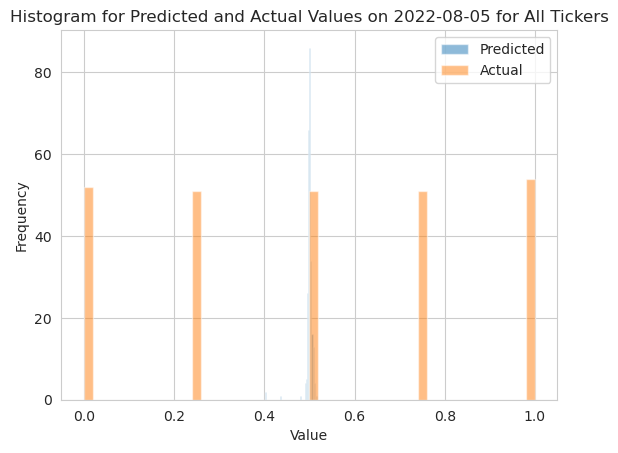

In [51]:
import matplotlib.pyplot as plt

# Define the specific date
specific_date = '2022-08-05'

# Filter dataset for the specific date across all tickers
filtered_data = preds.loc[(slice(None), specific_date), :]

# Plot histogram for 'predicted' values
filtered_data['predicted'].hist(bins=50, alpha=0.5, label='Predicted')

# Plot histogram for 'actual' values on top
filtered_data['actual'].hist(bins=50, alpha=0.5, label='Actual')

# Add title and labels
plt.title(f'Histogram for Predicted and Actual Values on {specific_date} for All Tickers')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
from scipy.stats import spearmanr

def calculate_daily_spearman_correlation(group):
    """Calculate the daily Spearman correlation between actual and predicted values."""
    return spearmanr(group['actual'], group['predicted'])[0]

# Compute the daily Spearman correlation for each date
spearman_correlations_daily = preds.groupby('date').apply(calculate_daily_spearman_correlation)

# Calculate the average Spearman correlation over all dates
average_spearman_correlation = spearman_correlations_daily.mean()

# Calculate the Sharpe ratio for each date
daily_sharpe_ratios = spearman_correlations_daily / spearman_correlations_daily.std()

# Convert the Sharpe ratios to a DataFrame
sharpe_ratios_dataframe = daily_sharpe_ratios.to_frame()
sharpe_ratios_dataframe.columns = sharpe_ratios_dataframe.columns.astype(str)
sb.glue("sharpe_ratios_per_day", sharpe_ratios_dataframe, display=False)

In [ ]:
# import matplotlib.pyplot as plt

# # Create a list of colors based on the sign of the Sharpe Ratios
# colors = ['blue' if value > 0 else 'red' for value in daily_sharpe_ratios]

# plt.figure(figsize=(12,6))
# daily_sharpe_ratios.plot(kind='bar', color=colors)
# plt.title('Daily Sharpe Ratios')
# plt.xlabel('Date')
# plt.ylabel('Sharpe Ratio')
# plt.grid(axis='y')
# plt.tight_layout()
# plt.axhline(y=0, color='black', linestyle='-')  # Add a horizontal line at y=0
# plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
# plt.show()
